# 6.1. Thiết kế pipeline

Đầu tiên chúng ta sẽ cần import các packages cần thiết. Hầu hết các project machine learning đều yêu cầu sử dụng 4 packages chính là numpy, pandas (đọc, ghi và biến đổi dữ liệu), matplotlib (biểu đồ hoá) và đặc biệt là sklearn (xây dựng mô hình). Để import các package chính thì chúng ta có thể sử dụng câu lệnh `import package as alias`, câu lệnh này sẽ import một package có tên là `package` và gán cho nó một cái tên ngắn gọn là alias trong toàn bộ file xử lý. Hoặc nếu chỉ muốn import một hàm hoặc class trong package thì bạn sử dụng câu lệnh `from package.module import class_or_funct`. Câu lệnh này sẽ import một class hoặc hàm số là `class_or_funct` bên trong `package.module`.

In [1]:
#from google.colab import drive
#import os

#drive.mount('/content/gdrive')
#os.chdir('gdrive/MyDrive/mybook')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## 6.1.1. Tìm hiểu về bộ dữ liệu German credit

German credit là bộ dữ liệu về lịch sử tín dụng của 1000 tài khoản khác nhau. Mục tiêu của chúng ta là dựa vào lịch sử tín dụng này để dự đoán khả năng khách hàng sẽ trả nợ hay không. Bộ dữ liệu bao gồm 20 biến đầu vào trong đó có 7 biến liên tục (numeric) và 13 biến phân loại (category). Nội dung của các biến từ 1 đến 20 lần lượt như sau:

* Trạng thái tài khoản hiện có.
* Kỳ hạn theo tháng (_Duration_)
* Lịch sử tín dụng
* Mục đích
* Dư nợ tín dụng (_Credit amount_)
* Tài khoản tiết kiệm (_Savings account_)
* Số năm làm việc liên tục gần nhất tới thời điểm hiện tại
* Tỷ lệ trả góp (_Installment rate_) theo thu nhập khả dụng
* Giới tính và trạng thái hôn nhân
* Những người nợ khác
* Thời gian cư trú tại nơi ở hiện tại
* Bất động sản
* Tuổi
* Trả góp khác
* Nhà ở
* Số lượng khoản vay tại ngân hàng
* Nghề nghiệp
* Số người phụ thuộc
* Điện thoại
* Có phải là lao động nước ngoài

Biến đầu ra (cột cuối cùng) gồm hai nhãn Good và Bad trong đó nhãn Good đại diện cho trường hợp Negative, tức khách hàng không trả nợ được và nhãn Bad đại diện cho các trường hợp Positive, khách hàng trả được nợ.

Đây là bộ dữ liệu mất cân bằng nhẹ khi nhãn Good chiếm 70% và nhãn Bad chỉ 30%. Điều này nhắc nhở chúng ta rằng dự báo đúng Positive là quan trọng hơn Negative. Có thể chúng ta sẽ cần đánh trọng số cho loss function sao cho các trường hợp False Negative (dự báo sai Positive thành Negative) sẽ bị đánh trọng số cao hơn False Positive (dự báo sai Negative thành Positive).

Tiếp theo ta sẽ đọc vào khảo sát bộ dữ liệu này.

In [2]:
import pandas as pd

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 header=None, names=['StaAcc', 'DuMon', 'CredHis', 'Purpose', 'CredAmt', 'SavAcc', \
                                     'PreEmpl', 'InsRt', 'PerSta', 'OthDebtor', 'PreRe', 'Property', \
                                     'Age', 'IntPla', 'Housing', 'ExstCredit', 'Job', 'NoMain', 'Phone', 'ForWorker', "Response"], 
                 index_col=None, sep=" ")
df.head()

,StaAcc,DuMon,CredHis,Purpose,CredAmt,SavAcc,PreEmpl,InsRt,PerSta,OthDebtor,...,Property,Age,IntPla,Housing,ExstCredit,Job,NoMain,Phone,ForWorker,Response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


**Các trường dữ liệu và định dạng**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StaAcc      1000 non-null   object
 1   DuMon       1000 non-null   int64 
 2   CredHis     1000 non-null   object
 3   Purpose     1000 non-null   object
 4   CredAmt     1000 non-null   int64 
 5   SavAcc      1000 non-null   object
 6   PreEmpl     1000 non-null   object
 7   InsRt       1000 non-null   int64 
 8   PerSta      1000 non-null   object
 9   OthDebtor   1000 non-null   object
 10  PreRe       1000 non-null   int64 
 11  Property    1000 non-null   object
 12  Age         1000 non-null   int64 
 13  IntPla      1000 non-null   object
 14  Housing     1000 non-null   object
 15  ExstCredit  1000 non-null   int64 
 16  Job         1000 non-null   object
 17  NoMain      1000 non-null   int64 
 18  Phone       1000 non-null   object
 19  ForWorker   1000 non-null   object
 20  Response 

Đây là bộ dữ liệu có chất lượng khá tốt, không có missing value ở các biến.

**Thống kê mô tả**

In [4]:
df.describe()

,DuMon,CredAmt,InsRt,PreRe,Age,ExstCredit,NoMain,Response
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


Kết quả thống kê mô tả sơ bộ trên các biến numeric cho thấy các biến khác biệt nhau về đơn vị lớn. Trung bình thấp nhất là 1.155 và cao nhất lên tới 3271.258. Như vậy khả năng cao chúng ta sẽ cần phải chuẩn hoá các biến để loại bỏ sự khác biệt về đơn vị trước khi xây dựng mô hình.

**Phân phối của các biến**

Chúng ta không nên tin tưởng hoàn toàn vào thống kê mô tả mà cần nhìn trực tiếp vào hình dạng phân phối của các biến. Điều này nhằm tránh những sai sót khi đánh giá về tính chất của biến khi chúng khác biệt xa nhau về phân phối. Điều này đã được giải thích trong [ví dụ phân phối chú khủng long](https://phamdinhkhanh.github.io/deepai-book/ch_appendix/appendix_matplotlib.html#density).

Chúng ta có thể dùng biểu đồ density kết hợp với histogram để tìm ra phân phối của biến.

Đối với biến liên tục.

number of numeric field:  8


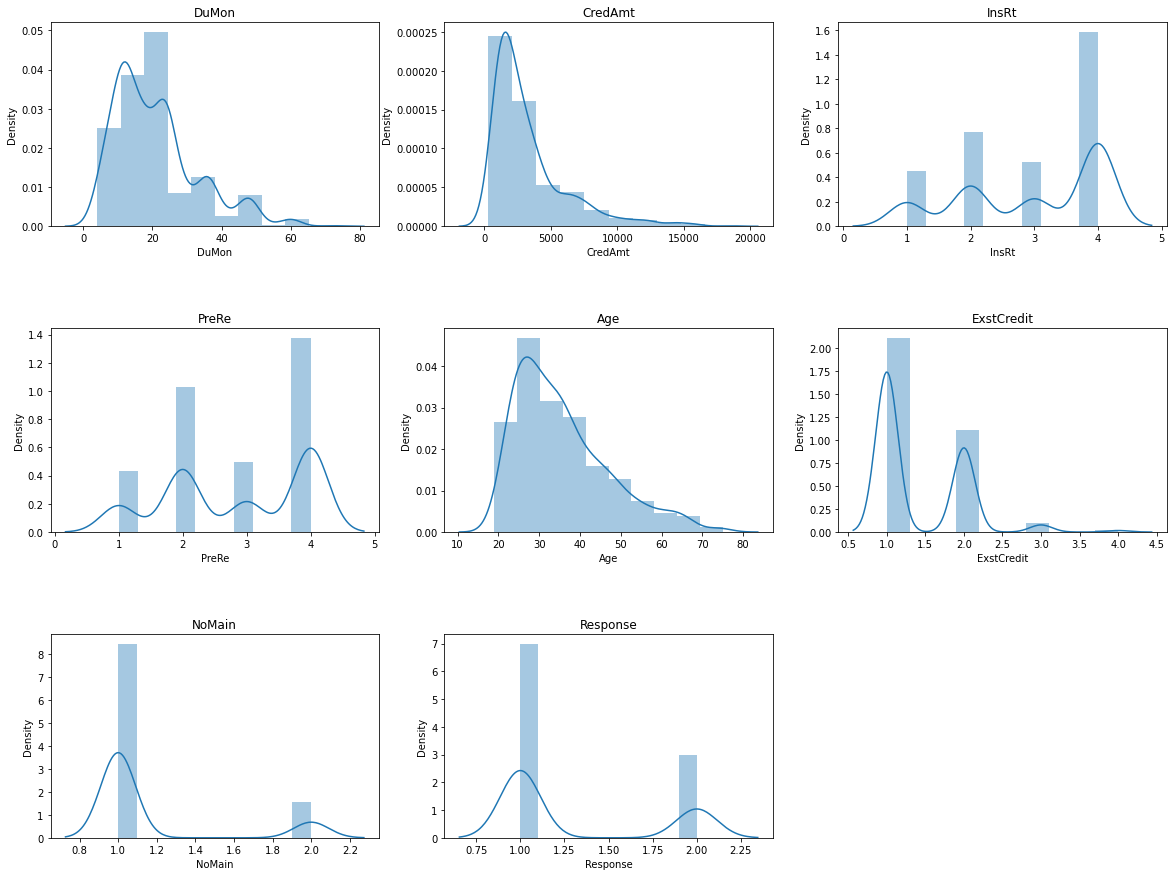

In [5]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numeric_cols = df.select_dtypes(include=['float','int']).columns

def _plot_numeric_classes(df, col, bins=10, hist=True, kde=True):
    sns.distplot(df[col],
                 bins = bins,
                 hist = hist,
                 kde = kde)

def _distribution_numeric(df, numeric_cols, row=3, col=3, figsize=(20, 15), bins = 10):
    '''
    numeric_cols: list các tên cột
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    bins: số lượng bins phân chia trong biểu đồ distribution
    '''
    print('number of numeric field: ', len(numeric_cols))
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

_distribution_numeric(df, numeric_cols)

Ta nhận thấy một số biến thực chất là biến thứ bậc khi các giá trị chỉ rơi vào một tập giá trị nhất định, chẳng hạn như biến `PreReg` chỉ nhận các giá trị `1, 2, 3, 4`. Khi nhìn vào biểu đồ phân phối của biến ta có thể nhận định đâu là miền mà các biến có mật độ tập trung cao và thấp? Kết hợp với kinh nghiệm business để đánh giá phân phối của biến có phù hợp với thực tế hay không? Đối với trường hợp có quá nhiều biến cần kiểm tra thì chúng ta có thể đối chiếu với phân phối của dữ liệu lịch sử để xem xét những thay đổi của biến. Điều này rất quan trọng vì sự thay đổi của biến sẽ ảnh hưởng trực tiếp tới đầu ra của mô hình.

Tương tự đối với biến phân loại chúng ta sẽ thống kê được tần suất giá trị của các nhãn trong một biến.

number of category field:  13


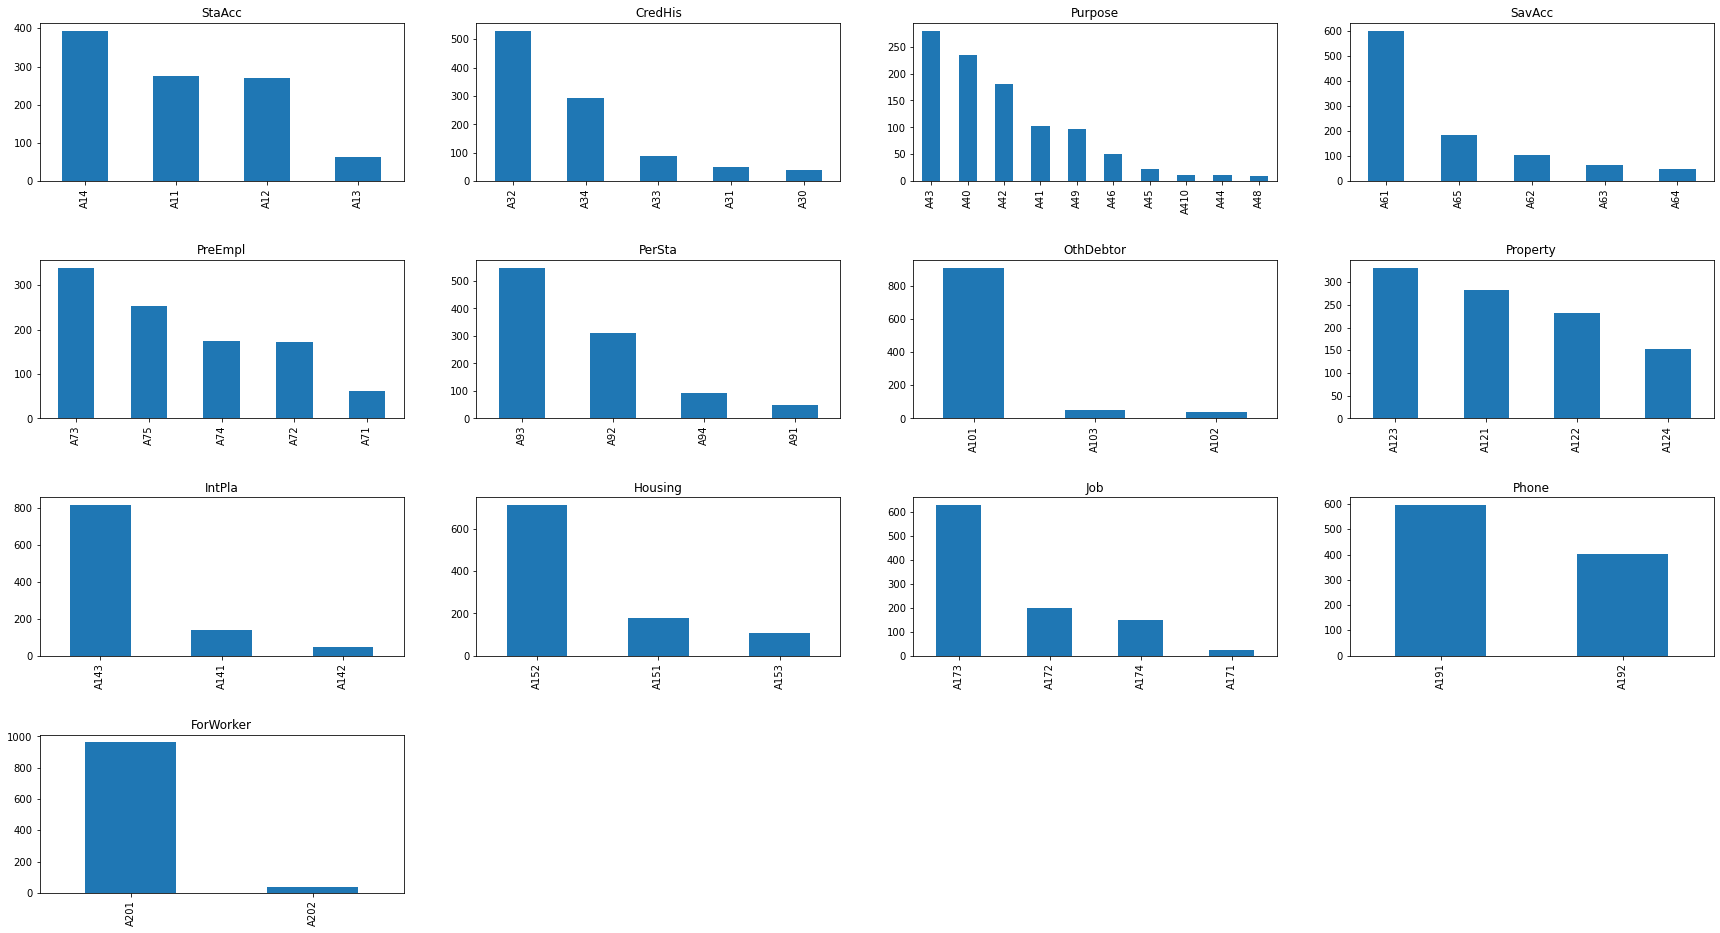

In [6]:
# Đối với biến phân loại
cate_cols = df.select_dtypes('O').columns

def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

def _distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (20, 5)):
  '''
  cate_cols: list các tên cột
  row: số lượng dòng trong lưới đồ thị
  col: số lượng cột trong lưới đồ thị
  figsize: kích thước biểu đồ
  '''
  print('number of category field: ', len(cate_cols))
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      _plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

_distribution_cate(df, cate_cols, row = 4, col = 4, figsize = (30, 16))

Ta nhận thấy có nhiều nhãn trong biến phân loại có số lượng quan sát rất ít. Theo kinh nghiệm thì các nhãn thiểu số lại có thể là đặc trưng riêng của một nhãn đầu ra. Vì thế chúng ta có thể khảo sát thêm tỷ lệ giữa GOOD/BAD cách biệt như thế nào ở những nhãn này. Kết quả đánh giá chúng có thể giúp ta đưa ra một số kết luận hữu ích đối với phân loại nhãn.

## 6.1.2. Phân chia tập train/val/test

Hầu hết các mô hình machine learning đều yêu cầu việc phân chia tập train/validation/test. Ở một số trường hợp dữ liệu ít thì chúng ta có thể chỉ cần phân thành tập train/validation. 

Mục đích của tập train là huấn luyện mô hình nên tập train cần chiếm tỷ lệ lớn để giúp mô hình học bao quát được các trường hợp của dữ liệu. Tập validation là tập dữ liệu sử dụng để đánh giá lại mô hình xem có xảy ra các hiện tượng overfitting và underfitting hay không? Những hiện tượng này cần được khắc phục nhằm giúp mô hình dự báo tốt hơn trên dữ liệu thực tế. 

Chúng ta thắc mắc nếu đã có tập validation thì tại sao lại cần thêm tập test? Tập test là một tập được lựa chọn sao cho phân phối và tính chất giống với dữ liệu thực tế nhất. Mục tiêu của tập này là để kiểm tra hiệu năng của mô hình nếu triển khai trên production. Thông thường kích thước tập test được lấy bằng tập validation. Để lựa chọn mô hình nào tốt nhất chúng ta sẽ căn cứ trên kết quả đánh giá trên tập test.

Tỷ lệ phân chia train/test khá đa dạng và không có qui định cụ thể. Theo kinh nghiệm, chúng ta có thể lấy theo các tỷ lệ `50:50` hoặc `70:30` nếu dữ liệu dồi dào, `80:20` hoặc `90:10` nếu dữ liệu ít.

Để phân chia dữ liệu chúng ta dùng hàm `train_test_split()`. Lựa chọn `stratify=df['Response']` để giúp cân bằng tỷ lệ `Good/Bad` trên cả train và test.

In [7]:
# Chia train/test theo tỷ lệ 80:20.
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['Response'])
X_train = df_train.copy()
y_train = X_train.pop("Response")

X_test = df_test.copy()
y_test = X_test.pop("Response")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 20) (800,)
(200, 20) (200,)


Tập validation sẽ được trích từ tập train ở trên theo tỷ lệ train/test=80/20. Cách chia này có thể cố định một lần hoặc thực hiện cross validation bằng cách chia thành K-Fold.

## 6.1.3. Preprocessing model

Bước tiếp theo là tiền xử lý dữ liệu. Ở bước này sẽ thực hiện các biến đổi chủ yếu nhằm biến dữ liệu thô chưa qua xử lý thành dữ liệu tinh có thể đưa vào mô hình huấn luyện. Trong sklearn hầu hết đã có sẵn những hàm chức năng giúp ta thực hiện các tiền xử lý dữ liệu một cách dễ dàng. Các xử lý chính bao gồm:

* Số hoá cho các biến đầu vào dạng phân loại (dùng `OneHotEncoder`).
* Xử lý missing data (dùng `SimpleImputer`).
* Loại bỏ các outlier (dùng `MinMaxScaler`).

Để kiểm soát các bước xử lý một cách tuần tự thì chúng ta sẽ thiết kế một pipeline khai báo các bước xử lý ở bên trong nó. Như vậy khi cần huấn luyện và dự báo chúng ta chỉ cần đưa vào dữ liệu thô vào pipeline để thu được đầu ra là dữ liệu tinh có thể huấn luyện và dự báo được.

## 6.1.4. Tách biệt xử lý cho biến liên tục và biến phân loại

Do các biến liên tục và biến phân loại có tính chất khác biệt nhau. Đối với biến liên tục thì có thể huấn luyện trực tiếp mô hình trên đó còn biến phân loại sẽ cần chúng ta mã hoá thành biến số học trước khi huấn luyện. Như vậy sẽ cần pipeline xử lý riêng cho từng loại biến. Để xây dựng pipeline trong sklearn chúng ta sử dụng hàm `Pipeline()`. Bên trong hàm này là một list gồm các steps xử lý theo tuần tự. Tiếp theo chúng ta sẽ thực hành thiết kế một pipeline mẫu cho bài toán này. Code mẫu cho bước này được tham khảo tại [pipeline đơn giản cho cuộc thi Titanic](https://machinelearningcoban.com/tabml_book/ch_intro/titanic_pipeline.html).

In [8]:
# Lấy list names của các biến phân loại và biến liên tục.
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [9]:
# Pipeline xử lý cho biến phân loại
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lý missing data bằng cách thay thế most frequent
        ('onehot', OneHotEncoder()), # Biến đổi giá trị của biến phân loại thành véc tơ OneHot
    ]
)

In [10]:
# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
           ('scaler', MinMaxScaler()) # Xử lý missing data bằng MinMax scaler
    ]
)

Các bạn nhận thấy các bước trong steps của `Pipeline` là một tuple gồm hai phần tử. Phần tử đầu tiên là tên của bước xử lý và phần tử thứ hai là phương pháp xử lý tương ứng. Việc đặt tên cho bước xử lý sẽ giúp ta nắm bắt được thứ tự và kiểm soát toàn bộ quá trình xử lý.

class `ColumnTransformer` trong sklearn là một phương pháp biến đổi được áp dụng trên các cột. Chúng ta có thể gộp chung hai biến đổi trên biến liên tục và phân loại như sau thông qua class này như sau:

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names), # áp dụng pipeline cho biến liên tục
        ('cat', cat_pl, cat_names), # áp dụng pipeline cho biến phân loại
    ]
)

Như vậy các biến liên tục được qui định trong list `num_names` sẽ áp dụng xử lý là pipeline `num_pl` và biến phân loại trong list `cate_names` sẽ áp dụng xử lý là pipeline `cat_pl`.

## 6.1.5. Pipeline hoàn chỉnh

Sau khi đã có Pipleline tiền xử lý dữ liệu hàn chỉnh thì chúng ta đã có thể thu được dữ liệu sạch ở đầu ra. Tiếp theo cần đưa dữ liệu đã làm sạch qua mô hình để huấn luyện. Cả hai bước tiền xử lý dữ liệu và huấn luyên mô hình có thể tiếp tục đóng gói trong một Pipeline như sau:

In [12]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("classifier", RandomForestClassifier())
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 1.00
Accuracy on test: 0.75


Như vậy chúng ta đã hoàn thiện một Pipeline đơn giản cho mô hình phân loại khả năng trả nợ. Mô hình có độ chính xác trên tập train là 100% và trên tập test là 77% cho thấy có hiện tượng overfitting. Để khắc phục overfitting chúng ta có thể thực hiện cross validation.

# 6.2. Đánh giá cheó (_cross validation_)

Đánh giá chéo là một **thủ tục lấy mẫu** được sử dụng để đánh giá các mô hình machine learning trong quá trình huấn luyện. Cụ thể trong đánh giá chéo (_cross validation_) chúng ta phân chia dữ liệu thành k-folds không chồng lấn, có kích thước bằng nhau. Ở mỗi lượt huấn luyện ta sẽ lựa chọn ra (k-1) folds để huấn luyện và fold còn lại để kiểm định. Như vậy đánh giá chéo sẽ đánh giá được khả năng dự báo của mô hình đối với dữ liệu mà nó chưa nhìn thấy. Căn cứ vào kết quả trên toàn bộ các folds thì chúng ta có thể rút ra kết luận về trung bình, phương sai của các thước đo đánh giá hiệu suất của mô hình và đưa ra đánh giá sơ bộ về sức mạnh của chúng.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

**Hình 1:** [Source - cross validation, sklearn](https://scikit-learn.org/stable/modules/cross_validation.html). Quá trình phân chia dữ liệu, huấn luyện và đánh giá mô hình dựa trên đánh giá chéo.

## 6.2.1. Lựa chọn thước đo mô hình

Lựa chọn thước đo cho mô hình là một công việc khó vì nó đòi hỏi người xây dựng mô hình phải hiểu sâu về vấn đề mình đang giải quyết và đồng thời có kiến thức chuyên môn về mô hình. 

Trong trường hợp là người chưa có kinh nghiệm bạn có thể lựa chọn các thước đo mô hình thông dụng của bài toán dự báo và bài toán phân loại như bên dưới.

### 6.2.1.1.Thước đo sơ bộ cho bài toán dự báo 

Trong bài toán dự báo thì chúng ta muốn sai số giữa giá trị dự báo và giá trị thực tế là nhỏ nhất nên MSE (_mean squared error_), RMSE (_root mean squared error_), MAE (_mean absolute error_) hoặc MAPE (_mean absolute percentage error_) thường được lựa chọn.

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2$$

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2)}$$

$$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i-\hat{y}_i|$$

$$\text{MAPE} = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_i-\hat{y}_i}{y_i}|$$

Nhìn vào công thức bạn cũng có thể hình dung sơ bộ ý nghĩa của các chỉ số này rồi chứ?

* MSE: Trung bình tổng bình phương sai số giữa giá trị dự báo và thực tế.
* RMSE: Khai căn bậc hai của MSE và nó đại diện cho độ lệch giữa giá trị dự báo và thực tế.
* MAE: Trung bình trị tuyệt đối của sai số giữa giá trị dự báo và thực tế.
* MAPE: Trung bình của tỷ lệ phần trăm sai số tuyệt đối giữa giá trị dự báo và thực tế.

### 6.2.1.2. Thước đo sơ bộ cho bài toán phân loại

Lấy ví dụ một bài toán phân loại nhị phân có bảng chéo thống kê kết quả giữa thực tế và dự báo như sau:

![](https://phamdinhkhanh.github.io/assets/images/20200813_ModelMetric/pic1.png)

Các chỉ số TP, FP, TN, FN lần lượt có ý nghĩa là :

* TP (True Positive): Tổng số trường hợp dự báo khớp Positive.
* TN (True Negative): Tổng số trường hợp dự báo khớp Negative.
* FP (False Positive): Tổng số trường hợp dự báo các quan sát thuộc nhãn * Negative thành Positive.
* FN (False Negative): Tổng số trường hợp dự báo các quan sát thuộc nhãn Positive thành Negative.

Đối với bài toán phân loại thì ta quan tâm tới độ chính xác dự báo trên toàn bộ bộ dữ liệu là bao nhiêu? do đó thước đo phổ biến nhất là `accuracy`. 

$$\text{Accuracy} = \frac{TP+TN}{\text{total sample}} = \frac{55+850}{1000} = 90.5 \%$$

**Bài tập:** Bạn hãy giải thích vì sao trong trường hợp mất cân bằng dữ liệu thì accuracy không còn là thước đo mô hình tốt?

Trong tính huống mô hình bị mất cân bằng thì accuracy không còn là thước đo tốt nên được thay thế bằng `precision, recall`. 

$$\text{Precision} = \frac{TP}{\text{total predicted positive}} = \frac{TP}{TP+FP} = \frac{55}{55+50} = 52.4 \%$$

$$\text{Recall} = \frac{TP}{\text{total actual positive}} = \frac{TP}{TP+FN} = \frac{55}{55+45}=55 \%$$

Hai chỉ số này lần lượt giúp đánh giá tỷ lệ dự báo chính xác positive trên tổng số trường hợp được dự báo là positive và tỷ lệ dự báo chính xác positive trên thực tế. Thực sự rất khó để nói lựa chọn `precision` hay `recall` là tốt hơn nên chúng ta dùng `f1-score` là trung bình điều hoà đại diện cho cả precision và recall. Ngoài ra còn một số chỉ số nâng cao hơn cũng được lựa chọn để đánh giá sức mạnh phân loại như `AUC, Gini Index, Cohen's Kappa` tuy nhiên `f1-score` và `accuracy` theo mình nghĩ vẫn là hai chỉ số cơ bản nhất cho bài toán phân loại mà bạn cần nắm vững.

$$f_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

$f_{\beta}$ là trường hợp tổng quát hơn của $f_1$ khi ta coi mức độ quan trọng của `recall` bằng $\beta$ lần `precision`.

$$\begin{eqnarray}
f_{\beta} & = & \frac{1+\beta^2}{\frac{1}{\text{precision}} + \frac{\beta^2}{\text{recall}}} \\
& = & \frac{(1+\beta^2) \times \text{precision} \times \text{recall}}{\beta^2 \text{precision}+\text{recall}} \\
& = & \frac{(1+\beta^2)\times\text{TP}}{(1+\beta^2)\times\text{TP}+\beta^2 \times \text{FN} + \text{FP}}
\end{eqnarray}$$

Bộ dữ liệu [german credit](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) có tính chất mất cân bằng nên chúng ta sẽ lựa chọn `f-score` thay cho `accuracy`. Hơn nữa trong mô tả của bộ dữ liệu đã qui định:

`It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).`

Tức là một trường hợp `False Negative` có mức độ sai lầm bằng 5 trường hợp `False Positive` nên ta sẽ lựa chọn $\beta^2=5$.

In [13]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy as np

# Tính fbeta score
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=np.sqrt(5))

### 6.2.1.3. Thực hiện cross validation

Để thực hiện cross validation chúng ta sử dụng class `RepeatedStratifiedKFold()` với `n_splits` là số lần chia dữ liệu và `n_repeates` là số lần lặp lại quá trình cross validation. Như vậy chúng ta sẽ có tổng cộng `n_splits x n_repeats = 30` lượt đánh giá dữ liệu.

Hàm `cross_val_score()` sẽ được sử dụng để tính toán thước đo mô hình trên các lượt huấn luyện.

In [14]:
# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Xác định metric cho mô hình
metric = make_scorer(fbeta)
# Đánh giá mô hình
scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta: 0.892 0.026


## 6.2.2. Đánh giá nhiều mô hình

Chúng ta có thể thực hiện vòng lặp để _đánh giá chéo_ nhiều lớp mô hình khác nhau. Sau đó so sánh phân phối điểm thu được của những lớp mô hình này để tìm ra đâu là mô hình có score lớn nhất.

In [15]:
# list các mô hình được lựa chọn
models = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
  completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('classifier', model)]
  )

  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  all_scores.append(scores)

Tiếp theo ta sẽ vẽ biểu đồ phân phối score giữa các mô hình.

Text(0.5, 1.0, 'Scores Metrics')

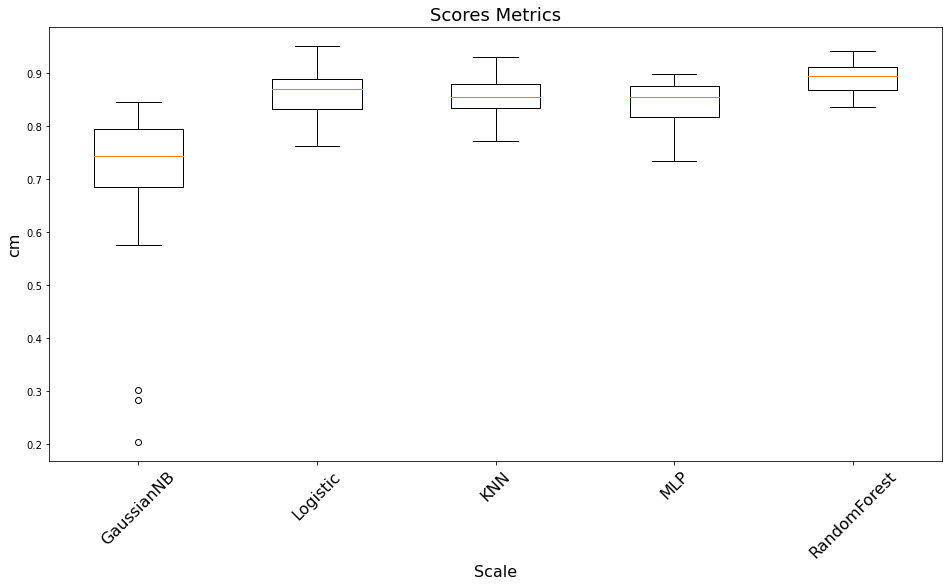

In [16]:
import matplotlib.pyplot as plt
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Scale', fontsize=16)
plt.ylabel('cm', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

Nhìn vào biểu đồ ta có thể thấy `RandomForest` là thuật toán có độ chính xác cao nhất khi score giao động trong khoảng từ 0.83 đến 0.95 và trung bình đạt được khoảng 0.9 nên chúng ta sẽ lựa chọn lớp mô hình này để phát triển thành production.

# 6.3. GridSearch

GridSearch là một kỹ thuật giúp tìm kiếm tham số phù hợp cho mô hình đối với một bộ dữ liệu cụ thể. Trong sklearn chúng ta có thể sử dụng `GridSearchCV` để tạo không gian tham số. Để dễ hình dung hơn về GridSearch chúng ta hãy cùng áp dụng chúng trên bộ dữ liệu `German Credit`.

Đầu tiên chúng ta sẽ tạo ra một Class `ClassifierfSwitcher` mà thuộc tính `estimator` của nó là một mô hình trong sklearn. Đây là một tham số có thể search được trên gridsearch.

In [17]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = RandomForestClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      
      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

Tiếp theo chúng ta sẽ kết hợp giữa hai bước tiền xử lý và huấn luyện để tạo thành một pipeline hoàn chỉnh và thực hiện gridsearch trên pipeline này.

In [18]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("pre", preprocessor), ("clf", ClassifierSwitcher())]
)

Pipeline sẽ gồm hai bước là `pre` và `clf`. Chúng ta chỉ cần quan tâm tới việc tìm kiếm trên `clf` thông qua các parameters của class `ClassifierSwitcher` như sau:

In [19]:
parameters = [
    {
        'clf__estimator': [LogisticRegression()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4]
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy')
    },
]

Giải thích một chút: Bạn không hiểu `clf__estimator__penalty` nghĩa là gì phải không? Bởi vì parameters sẽ được thông dịch trước khi đưa vào gridsearch nên dấu `__` ở trên chính là dấu `.` sau khi thông dịch. Như vậy `clf__estimator__penalty` chính là `clf.estimator.penalty`.

Tiếp theo ta sẽ thực hiện grid search trên tập train. Quá trình grid search sẽ thực hiện cross validation với k=5 và kết quả để quyết định mô hình tốt nhất là trung bình trên 5 lượt đánh giá theo hàm fbeta.

In [20]:
metric = make_scorer(fbeta)
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=7)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DuMon',
                                                                          'CredAmt',
                                                                          'InsRt',
                                                                          'PreRe',
                                                                          'Ag

Để tìm ra mô hình tốt nhất từ `grid search` ta sử dụng `gscv.best_estimator_`.

In [21]:
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DuMon', 'CredAmt', 'InsRt',
                                                   'PreRe', 'Age', 'ExstCredit',
                                                   'NoMain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                      

Các tham số tốt nhất.

In [22]:
gscv.best_params_

{'clf__estimator': RandomForestClassifier(max_depth=5),
 'clf__estimator__criterion': 'gini',
 'clf__estimator__max_depth': 5,
 'clf__estimator__n_estimators': 100}

Điểm số cao nhất.

In [23]:
gscv.best_score_

0.9293410047394814

# 6.4. Tổng kết

Xây dựng pipeline là một kỹ thuật quan trọng trong quá trình huấn luyện và đánh giá các mô hình machine learning. Nhờ kỹ thuật này chúng ta có thể tự động hoá quá trình phức tạp thành một hệ thống pipeline đơn giản mà có thể trực tiếp dự báo dựa trên dữ liệu thô.

Đồng thời qua bài viết các bạn cũng học được cách lựa chọn một số metrics cơ bản trong đánh gía mô hình phân loại và mô hình dự báo và kỹ thuật gridsearch giúp tìm kiếm mô hình trên không gian tham số. Đây là những kiến thức nền tảng rất quan trọng giúp bạn xây dựng và triển khai các bài toán thực tế.

Tiếp theo là phần bài tập giúp bạn hệ thống lại kiến thức của chương này.

# 6.5. Bài tập

Từ một trong các bộ dữ liệu:

* [BreastCancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) về chuẩn đoán ung thư vú. 
* [diabetes](https://archive.ics.uci.edu/ml/datasets/diabetes) chuẩn đoán bệnh tiểu đường.
* [hmeq](https://www.kaggle.com/ajay1735/hmeq-data) phân loại hồ sơ cho vay mua nhà.
* [BonstonHousing](https://github.com/phamdinhkhanh/datasets/blob/master/BostonHousing.csv) dự báo giá nhà ở Bonston. 
* [churn customer](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) dự đoán khách hàng rời bỏ.

Bạn hãy thực hiện các bài tập sau: 

1. Thống kê mô tả và vẽ biểu đồ phân phối trên các trường của tập dữ liệu này. Đánh giá sơ bộ về tính chất phân phối của các biến.

2. Hãy tạo thành một pipeline hoàn chỉnh để xử lý dữ liệu từ thô sang tinh.

3. Phân chia tập train/test và lựa chọn metric cho bài toán.

4. Lựa chọn một lớp mô hình phù hợp, thực hiện cross validation để huấn luyện và đánh giá mô hình đó trên tập train.

5. Triển khai lại quá trình ở bài 4 trên nhiều lớp mô hình khác nhau.

6. Vẽ biểu đồ thể hiện kết quả của các mô hình và Kết luận đâu là mô hình tốt nhất. 

7. Dựa vào lớp mô hình tốt nhất được lựa chọn, thực hiện grid search trên không gian tham số của nó.

# 6.6. Tài liệu tham khảo

1. [sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
2. [hands on tutorial ML Pipeline](https://analyticsindiamag.com/hands-on-tutorial-on-machine-learning-pipelines-with-scikit-learn/)
3. [pipeline đơn giản cho cuộc thi titanic](https://machinelearningcoban.com/tabml_book/ch_intro/titanic_pipeline.html)
4. [Simplified Mixed Feature Type Preprocessing in Scikit-Learn with Pipelines](https://www.kdnuggets.com/2020/06/simplifying-mixed-feature-type-preprocessing-scikit-learn-pipelines.html)
5. [Đánh giá mô hình phân loại trong ML - khanhblog](https://phamdinhkhanh.github.io/2020/08/13/ModelMetric.html)
6. [managing machine learning workflows scikit learn pipelines](https://www.kdnuggets.com/2017/12/managing-machine-learning-workflows-scikit-learn-pipelines-part-1.html)